In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import multiprocessing as mp
import pandas as pd
import numpy as np
from functools import partial
import random

from helper_functions import *

In [4]:
np.zeros(100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_preds)
    dem = ((np.abs(y_true) + np.abs(y_true)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.men(smap)

In [17]:
%%time
if __name__ == '__main__':
    HORIZON = 8
    WINDOW_SIZE = 8

    train = pd.read_csv('train.csv')
    IDS = train.cfips.unique()

    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(31,39).reshape((-1,1))
    random_ids = random.sample(list(IDS), 10)
    window_size = WINDOW_SIZE
    horizon = HORIZON
    epoch = 500
    
    cfips_list = []
    mapes = []
    density_values = []
    active_size = []
    forecasts = []

    pool = mp.Pool(16)

    func = partial(train_get_result, train, window_size, horizon, epoch)
    results = pool.map(func, random_ids)
    pool.close()
    pool.join()
    
    # Create DataFrame
    for i in range(len(results)):
        c = results[i][0]
        cfips_list.append(c)
        last_density = results[i][1]
        density_values.append(last_density)
        last_active = results[i][2]
        active_size.append(last_active)
        mape = results[i][3]
        mapes.append(mape)
        preds = results[i][4]
        x = np.array(preds).reshape((-1))
        preds = x.astype(np.float64)
        forecasts.append(preds)
    
    result_df = pd.DataFrame({'Country': cfips_list,
                             'MAPE': mapes,
                             "Density": density_values,
                             'Active': active_size,
                             'forecast': forecasts})

CPU times: total: 203 ms
Wall time: 12.5 s


In [18]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   10 non-null     int64  
 1   MAPE      10 non-null     float32
 2   Density   10 non-null     float64
 3   Active    10 non-null     int64  
 4   forecast  10 non-null     object 
dtypes: float32(1), float64(1), int64(2), object(1)
memory usage: 488.0+ bytes


In [23]:
type(result_df.iloc[0]['forecast'][0])

numpy.float64

## Plot randomly

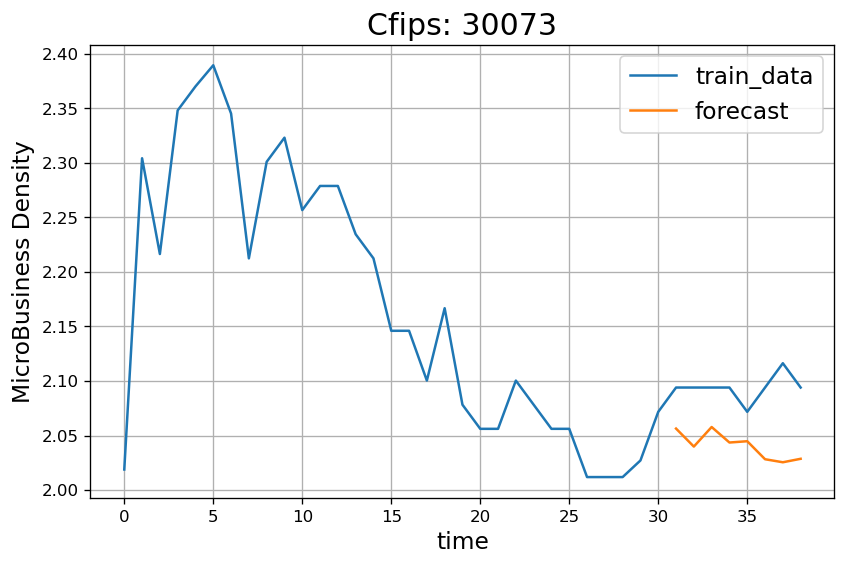

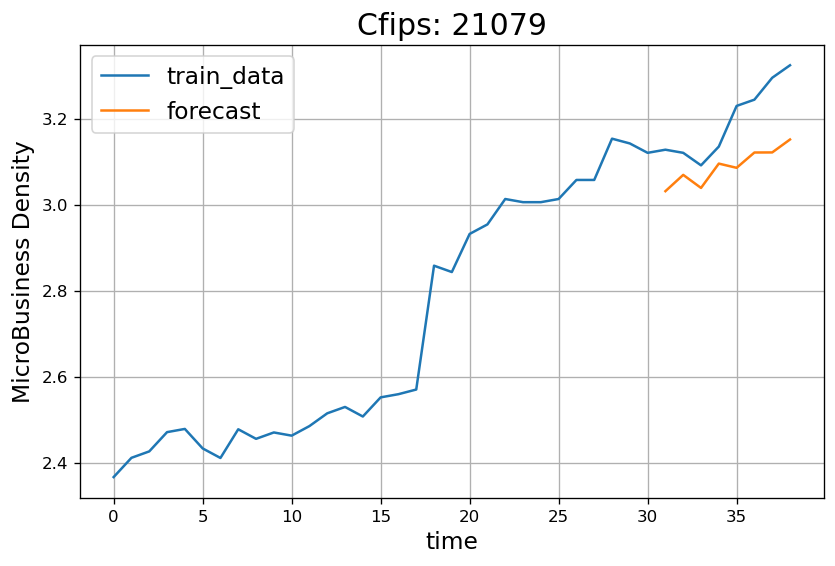

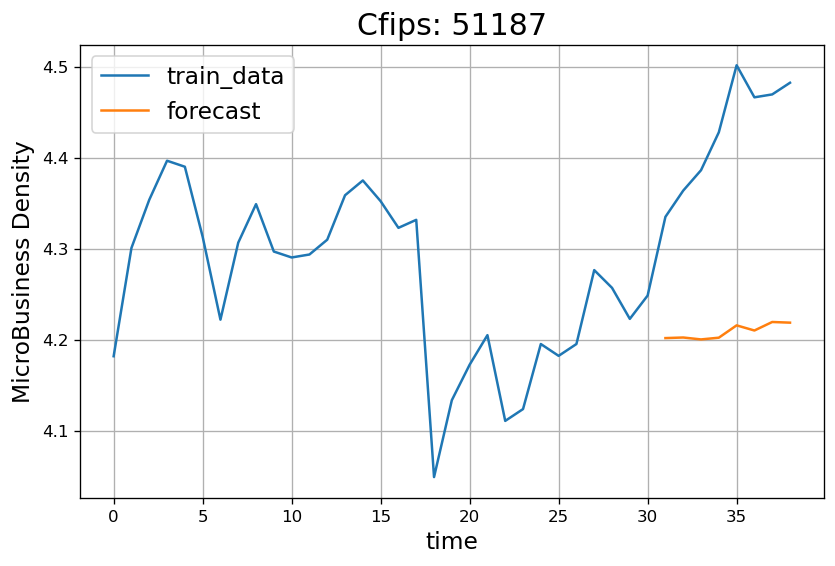

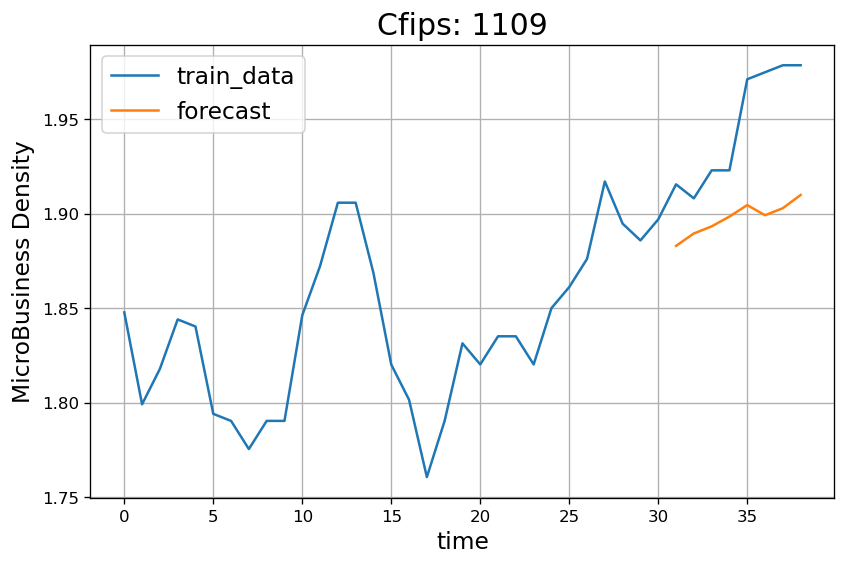

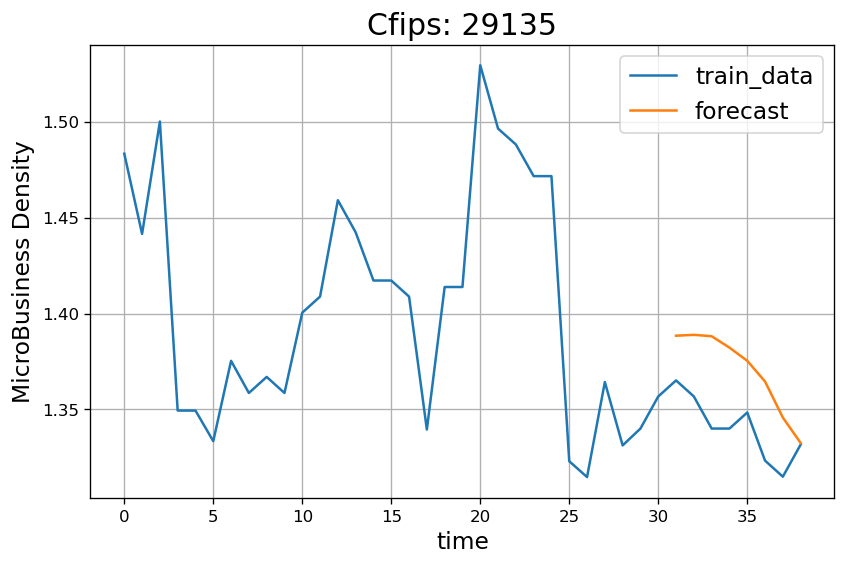

In [15]:
for idx in random.sample(list(result_df.index), 5):
    c = result_df.loc[idx].Country
    df = train[train.cfips == c]
    preds = result_df.loc[idx].forecast
    plot_time_series(c, x_train, df.microbusiness_density.values, label='train_data')
    plot_time_series(c, x_test, preds, label='forecast')
    plt.show()

In [18]:
(3*60 + 52) / 47.1

4.925690021231422

In [19]:
2*60 / 4.92

24.390243902439025

## Conclusion:

Without multiprocessing, the process for 100 countries took about 3min 52sec. It took 47.1sec with using multiprocessing, so about 5 times quicker process with multiprocessing. 

With Dense layer, the process took almost 2 hours but with multiprocessing, it should take 24 min. 

In [2]:
%%time
if __name__ == '__main__':
    HORIZON = 8
    WINDOW_SIZE = 8

    train = pd.read_csv('train.csv')
    IDS = train.cfips.unique()

    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(31,39).reshape((-1,1))
    window_size = WINDOW_SIZE
    horizon = HORIZON
    epoch = 500
    
    cfips_list = []
    mapes = []
    density_values = []
    active_size = []
    forecasts = []

    pool = mp.Pool(16)

    func = partial(train_get_result, train, window_size, horizon, epoch)
    results = pool.map(func, IDS)
    pool.close()
    pool.join()
    
    # Create DataFrame
    for i in range(len(results)):
        c = results[i][0]
        cfips_list.append(c)
        last_density = results[i][1]
        density_values.append(last_density)
        last_active = results[i][2]
        active_size.append(last_active)
        mape = results[i][3]
        mapes.append(mape)
        preds = results[i][4]
        x = np.array(preds).reshape((-1))
        preds = x.astype(np.float64)
        forecasts.append(preds)
    
    result_df = pd.DataFrame({'Country': cfips_list,
                             'MAPE': mapes,
                             "Density": density_values,
                             'Active': active_size,
                             'forecast': forecasts})

CPU times: total: 5.27 s
Wall time: 15min 50s


In [3]:
result_df

Country      MAPE    Density  Active  \
0        1001  1.504614   3.334431    1417   
1        1003  4.143341   7.823300   13401   
2        1005  1.395184   1.206827     239   
3        1007  5.228748   1.236650     220   
4        1009  1.442244   1.777708     789   
...       ...       ...        ...     ...   
3130    56037  8.937141   2.892446     927   
3131    56039  3.437833  25.438322    4875   
3132    56041  4.339746   3.954258     574   
3133    56043  2.373714   3.027295     183   
3134    56045  1.285249   1.749688      98   

                                               forecast  
0     [3.3091351985931396, 3.317270278930664, 3.3280...  
1     [7.858337879180908, 7.885188579559326, 7.90744...  
2     [1.1614106893539429, 1.165130376815796, 1.1701...  
3     [1.2229969501495361, 1.2201088666915894, 1.220...  
4     [1.7523701190948486, 1.763606071472168, 1.7706...  
...                                                 ...  
3130  [3.103306531906128, 3.1108644008636475, 3.0841...  
3131  [25.547161102294922, 25.464475631713867, 25.21...  
3132  [3.8359427452087402, 3.8082215785980225, 3.818...  
3133  [3.0504283905029297, 3.074357509613037, 3.1034...  
3134  [1.730404257774353, 1.750791311264038, 1.76322...  

[3135 rows x 5 columns]

In [4]:
result_df.to_csv("dense_results_full_data.csv", index=False)

I saved the resuts as dense_results_full_data.csv. It only took less than 17 munites. I will use this results for analyze then find a way to maximize MAPE>

In [27]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   3135 non-null   int64  
 1   MAPE      3135 non-null   float32
 2   Density   3135 non-null   float64
 3   Active    3135 non-null   int64  
 4   forecast  3135 non-null   object 
dtypes: float32(1), float64(1), int64(2), object(1)
memory usage: 110.3+ KB


In [31]:
type(result_df.iloc[0]['forecast'][0])

numpy.float64

In [43]:
# List of forecasts to put on pandas dataframe to numpy array the reshape it. This will make 1D array. 
len(np.array(forecasts).reshape((-1)))

25080